# 针对Stable Diffusion-XL的prompt优化

Stable Diffusion-XL是一种基于Transformer的文本生成模型，其结构与GPT-3类似。本文将介绍如何利用prompt优化Stable Diffusion-XL的生成效果。

In [1]:
import os

# 初始化百度智能云的IAM ak, sk用于bos和千帆平台的鉴权
# 大模型平台和Bos同处于百度智能云下，所以可以使用同一个AK，SK来通过权限校验
os.environ['QIANFAN_ACCESS_KEY'] = 'your_access_key'
os.environ['QIANFAN_SECRET_KEY'] = 'your_secret_key'

In [2]:
import qianfan
from PIL import Image 
import io
from qianfan.common import Prompt
from qianfan import Completion


## 案例一：蚂蚁上树
* 蚂蚁上树在中文中指代的是肉末粉条这一传统菜品，若直译为英文，则可能会造成歧义。
* 这里以“蚂蚁上树”为例，来展示我们的prompt优化针对中文歧义词的效果。

首先我们先创建一个简单的任务描述prompt:

In [3]:
p = Prompt("蚂蚁上树")
pt = "蚂蚁上树"

使用优化前的prompt测试效果

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=pt, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

![alt text](img/ant_raw.png)

接下来，将上述prompt进行优化，提升图片的生成效果:

In [7]:
def prompt_update(pt):
    mission = """
    你的任务是将输入prompt进行优化,它应包括关于图像的详细的说明, 以指导人工智能创建精致准确的图像。优化后的prompt应有以下特点:
    1.它应将提示翻译成英文，并且在翻译的过程中注意一些语言上的歧义。
    2.它具体描述出图像中的更多主体内容，并且给部分需要重点突出的主体内容给予适当的权重
    3.它应在最后给出相应的negative prompt，它是一些与图像主题不相关的描述。
    4.它的长度不应超过100个词。
    5.如果输入的prompt没有明确的清晰度要求，请在输出prompt中默认清晰度为8k。
    下面是一些示例：
    [示例1]:
    输入prompt: “夫妻肺片”。
    输出prompt: “夫妻肺片, sliced beef with beef offal, spicy sauce, vibrant colors, photorealistic, food photography, close-up shot, richly textured, appetizing, culinary presentation, (detailed garnish:1.3), high resolution, 8k
                Negative prompt: text, logos, watermarks, out of frame, unattractive, discolored, unappetizing”。
    [示例2]:
    输入prompt: "一只高贵的柯基犬，素描画风格”。
    输出prompt: “Noble Corgi, sketch style, detailed line work, elegant, artistic, black and white, portrait, (intricate details:1.3), high resolution, 8k
                Negative prompt: text, logos, watermarks, out of frame, messy, blurry, extra limbs.” 
    [示例3]:
    输入prompt: “一个未来的城市图景，有车，楼，飞机，会飞的物体，人们的交通出行方式多样，生活有很大变化，天很蓝，有很多云彩，有阳光，有树，有草，有花，有很多东西。”
    输出prompt: "futuristic cityscape, (advanced buildings:1.4), (futuristic transportation:1.4), flying vehicles, various transportation modes, significant lifestyle changes, blue sky, many clouds, sunlight, trees, grass, flowers, highly detailed, photorealistic, high clarity, 8k, intricate architectural detailing, bustling city life
                Negative prompt: text, logos, watermarks, out of frame, ugly, extra limbs, extra hands, extra feet, extra fingers, bad anatomy。 "以下是你需要优化的输入prompt: 
    [示例4]:
    输入prompt:"金发维京女人"
    输出prompt:" a beautiful fashion blond viking woman, revealing outfit, symmetrical, maximalist, lily frame, art by ilya kuvshinov, rossdraws, sharp focus, art by wlop and artgerm,  extreme detail, detailed drawing, hyper detailed face
                Negative prompt: text, logos, watermarks, out of frame, unattractive, discolored, unappetizing, unrealistic, unnatural, unusual, unusual pose, unusual expression, unusual clothing, unusual accessories, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear, unusual makeup, unusual hairstyle, unusual eyewear"
    """
    input_prompt = mission + pt
    p = Prompt(input_prompt)
    return p
    #print(input_prompt)





In [8]:
p = prompt_update(pt)

comp = Completion(model="ERNIE-3.5-8K")
r = comp.do(prompt=p.render()[0])
output = r['result']
print(output)

An ant climbing a tree, realistic detail, intricate texture, natural lighting, vibrant colors, sharp focus, photorealistic rendering, intricate branches, ants moving dynamically, high resolution, 8k

Negative prompt: text, logos, watermarks, out of frame, cartoonish, simplified, abstract, blurred, grainy, low quality, unrealistic lighting, unnatural colors, mutated ants, mutated tree.


以下为优化prompt的生成效果展示：

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=pt, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

![alt text](img/ant_update.png)

## 案例二：一只凤凰飞过山
* 还有一类prompt，它们在理解上并没有歧义，但是包含的细节极少，无法给到足够的提示，可能会导致生成效果不佳。
* 这里我们以一只凤凰飞过山的任务为例，来展示我们的prompt优化针对扩展提示词的效果。

首先我们先创建一个简单的任务描述prompt:

In [95]:

p = Prompt("一只凤凰飞过山")
pt = "一只凤凰飞过山"

使用优化前的prompt测试效果

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=pt, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

![alt text](img/pheonix_raw.png)



接下来，将上述prompt进行优化，提升图片的生成效果:

In [98]:
p = prompt_update(pt)
comp = Completion(model="ERNIE-3.5-8K")

r = comp.do(prompt=p.render()[0])
output = r['result']
print(output)

A phoenix soaring over a mountain range, vibrant feathers of red, orange, and gold, fiery trail behind, detailed plumage, mountainous landscape, photorealistic, highly detailed, cinematic lighting, 8k

Negative prompt: text, logos, watermarks, out of frame, blurry, discolored, cartoonish, unnatural poses.




以下为优化prompt的生成效果展示：

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=pt, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

![alt text](img/pheonix_up.png)

从以上所展示的图片可以看出，整体表现力大大提升。主要表现如下：
1. 图片中加入了很多细节元素，比如奔腾的马蹄的运动状态，底面尘土的飞扬。
2. 图片的整体色彩有很大提升，不是以单薄的黑白配色为主，加入了黄色的星球。
3. 主体在图片中更为突出，使观看者能一眼了解主题状态。

## 案例三：长提示词的优化(1)
* 在用户提供较长提示词的情景下，提示词中可能会包含过多的主体，导致生成模型无法把握生成图片的主次需求，造成图片主体混乱的情况。因此，我们会对内容丰富的提示词进行主次的权重配比，以保证画面的结构性。
* 输入prompt为：一幅画，画中一只狗打扮成厨师，端着一碗食物。


首先我们先创建一个简单的任务描述prompt:

使用优化前的prompt测试效果

In [35]:
p = Prompt("一幅画，画中一只狗打扮成厨师，端着一碗食物")
pt = "一幅画，画中一只狗打扮成厨师，端着一碗食物"

使用优化前的prompt测试效果

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=pt, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

![alt text](img/dog_raw.png)

接下来，将上述prompt进行优化，提升图片的生成效果:

In [38]:
p = prompt_update(pt)
comp = Completion(model="ERNIE-3.5-8K")

r = comp.do(prompt=p.render()[0])
output = r['result']
print(output)

A painting of a dog dressed as a chef holding a bowl of food, detailed illustration, cartoon style, bright colors, funny expression, realistic dog features, chef's hat and apron, steaming food, cute and charming, hyper realistic, high resolution, 8k

Negative prompt: text, logos, watermarks, out of frame, blurry, unrealistic features, unattractive, discolored, unrelated objects, humans, other animals.


以下为优化prompt的生成效果展示：

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=output, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

![alt text](img/dog_up.png)

## 案例四：长提示词的优化(2)
* 输入prompt为：一条狗，一只猫，耶稣在中间照顾所有的生物，有人，有植物


首先我们先创建一个简单的任务描述prompt:

使用优化前的prompt测试效果

In [29]:
p = Prompt("一条狗，一只猫，耶稣在中间照顾所有的生物，有人，有植物")
pt = "一条狗，一只猫，耶稣在中间照顾所有的生物，有人，有植物"

使用优化前的prompt测试效果

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=pt, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
img.show()

接下来，将上述prompt进行优化，提升图片的生成效果:

In [31]:
p = prompt_update(pt)
comp = Completion(model="ERNIE-3.5-8K")

r = comp.do(prompt=p.render()[0])
output = r['result']
print(output)

a scene depicting a dog, a cat, and Jesus in the middle caring for all creatures, including humans and plants, religious iconography, harmonious coexistence, Jesus's loving gaze, vibrant colors, photorealistic rendering, detailed textures, emotional expression, sense of peace and tranquility, (emphasis on Jesus's role:1.5), high resolution, 8k

Negative prompt: text, logos, watermarks, out of frame, cartoony, unrealistic colors, violent or disturbing imagery.


以下为优化prompt的生成效果展示：

In [ ]:
t2i = qianfan.Text2Image()
resp = t2i.do(prompt=output, with_decode="base64")
img_data = resp["body"]["data"][0]["image"]

img = Image.open(io.BytesIO(img_data))
display(img)

![alt text](img/god_up.png)

## 效果评估




根据DiffusionDB的数据集，我们构造了一个简单的中文prompt测试集：

In [11]:
rawdata = [
    "黄昏谷仓画", "绿树成荫，花团锦簇","一只高贵的柯基犬","宫保鸡丁","一个摆满玩具机器人的房间","一座有许多雕像在里面的丛林寺庙","两匹马的黑白照片","一座庞大的宫殿,皇帝坐在正中央,大臣们骑着扫帚在殿内朝拜,有的大臣在汇报工作,整个大殿金碧辉煌","一只可爱的小猫","一座哥特式建筑","一对肝胆相照的兄弟","一只蜗牛",
    "一个挑灯夜读的高中生,他坐在电脑桌前","咖啡色的天空，绿色的湖，蓝色的草地","神圣的金字塔，门口坐着狮身人面像","两只猫鼬在野外和热气球在一起","一幅描绘白裙少女在雏菊田中翩翩起舞的画作","春天来了，万物复苏","火光冲天的未来飞船","一条狗，一只猫，耶稣在中间照顾所有的生物，有人，有植物","蚂蚁上树","夫妻肺片","一只飞过山的凤凰","机器人大战","虫虫危机"
]

定义文生图-保存函数：

In [10]:
def to_image(data):
    count = 0
    for pt in rawdata:
        #print(count)
        t2i = qianfan.Text2Image()
        resp = t2i.do(prompt=pt, with_decode="base64")
        img_data = resp["body"]["data"][0]["image"]

        img = Image.open(io.BytesIO(img_data))
        #display(img)

        # 设置保存路径
        save_dir = "your_save_path/raw"
        save_path = os.path.join(save_dir, f"{count}.png")

        # 确保保存目录存在
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # 保存图片
        img.save(save_path)
        print(f"Image {count} saved as {save_path}")

        count += 1

首先，将优化前的图片保存到自定义的文件夹中

In [32]:
to_image(rawdata)

Image 0 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/0.png
Image 1 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/1.png
Image 2 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/2.png
Image 3 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/3.png
Image 4 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/4.png
Image 5 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/5.png
Image 6 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/raw/6.png
Image 7 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/ra

In [12]:
mission_prompt = []
for pt in rawdata:
    p = prompt_update(pt)
    mission_prompt.append(p)
#print(input_prompt)

In [14]:
update_prompt = []
for i in range(len(mission_prompt)):
    #print(i)
    p = mission_prompt[i]
    comp = Completion(model="ERNIE-3.5-8K")

    r = comp.do(prompt=p.render()[0])
    
    output = r['result']
    update_prompt.append(output)
    print(output)
#print(update_prompt)


a painting of a rustic barn at dusk, golden hour lighting, soft shadows, warm tones, detailed textures, photorealistic, artistic style, painterly brushstrokes, romantic, peaceful atmosphere, (enhanced details:1.3), high resolution, 8k

Negative prompt: text, logos, watermarks, out of frame, modern buildings, cars, technology, bright colors, unnatural lighting, cartoonish, abstract, distorted, ugly, blurry.
a lush green forest, blooming flowers, vibrant colors, dense foliage, diverse plant species, sunlit paths, natural lighting, photorealistic, detailed texturing, intricate botanical details, serene atmosphere, peaceful environment, high clarity, 8k

Negative prompt: text, logos, watermarks, out of frame, ugly, distorted, artificial, mutated, cartoon, comic, simplified, bad anatomy, mechanical, cgi, matte painting, digital art, illustration, painting
A noble Corgi, regal posture, elegant fur, intricate details, art by wlop and rossdraws, hyper realistic, photorealistic, sharp focus, in

In [29]:
count = 0
for pt in update_prompt:
    t2i = qianfan.Text2Image()
    resp = t2i.do(prompt=pt, with_decode="base64")
    img_data = resp["body"]["data"][0]["image"]

    img = Image.open(io.BytesIO(img_data))
    #display(img)

    # 设置保存路径
    save_dir = "your_save_path/raw"
    save_path = os.path.join(save_dir, f"{count}.png")

    # 确保保存目录存在
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 保存图片
    img.save(save_path)
    print(f"Image {count} saved as {save_path}")

    count += 1

Image 0 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/0.png
Image 1 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/1.png
Image 2 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/2.png
Image 3 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/3.png
Image 4 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/4.png
Image 5 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/5.png
Image 6 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aesthetics-score-main/update/6.png
Image 7 saved as /Users/jianruitian/Documents/sdk/bce-qianfan-sdk-main/cookbook/prompt_update/aes

# 进行美学评分

* Aesthetics Score 是一种衡量图像美学素质的数值指标。
* 该指标的计算方法是将图像的不同视觉特征（如色彩、形状、线条、纹理、光照、透视、空间分布等）的重要程度进行加权，并将加权结果乘以相应的权重，得到的结果即为图像的美学得分。
* 美学得分的范围从 0 到 10，数值越高，图像的视觉效果越好。
* 此处，我们引入美学得分来衡量我们的prompt优化效果

In [15]:
!python -m venv venv
!pip install -r requirements.txt

  Using cached clip-1.0-py3-none-any.whl


In [16]:
import ae_score
#print(ae_score.result)

首先，对未优化的prompt生成的图片进行评测：

In [6]:
!python3 ae_score.py raw
result_file = "result.txt"
with open(result_file, "r") as file:
    result = float(file.read())
with open('filename.txt', 'w') as file:
    file.truncate()

raw_score = result

Loading sac+logos+ava1-l14-linearMSE
Loading CLIP ViT-L/14
100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.17it/s]16.png 6.8732428550720215
7.png 6.865425109863281
1.png 6.784933090209961
18.png 6.7444000244140625
5.png 6.7313947677612305
0.png 6.590202331542969
12.png 6.5729079246521
22.png 6.2540483474731445
13.png 6.181968688964844
15.png 6.098599433898926
6.png 6.046545028686523
2.png 6.041029930114746
8.png 6.033477783203125
19.png 5.950916767120361
14.png 5.9338603019714355
10.png 5.8986663818359375
24.png 5.768111228942871
9.png 5.747403144836426
17.png 5.718369960784912
20.png 5.7173237800598145
11.png 5.677421569824219
3.png 5.602540016174316
21.png 5.555800437927246
4.png 5.536472320556641
23.png 5.463445663452148
average score: 6.095540275573731
100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.19it/s]


接下来，对已优化的prompt生成的图片进行评测：

In [9]:
!python3 ae_score.py update/
result_file = "result.txt"
with open(result_file, "r") as file:
    result = float(file.read())
with open('filename.txt', 'w') as file:
    file.truncate()

update_score = result

Loading sac+logos+ava1-l14-linearMSE
Loading CLIP ViT-L/14
100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.16it/s]17.png 7.243247032165527
12.png 7.086347579956055
16.png 7.0605878829956055
1.png 6.963512897491455
0.png 6.95967960357666
5.png 6.796309471130371
13.png 6.795547008514404
22.png 6.794119834899902
3.png 6.622880935668945
15.png 6.577589988708496
2.png 6.4476518630981445
7.png 6.444652080535889
10.png 6.432063579559326
14.png 6.400423049926758
20.png 6.357996463775635
11.png 6.24599552154541
6.png 6.230348587036133
23.png 6.177926540374756
18.png 6.153735160827637
8.png 6.1326518058776855
4.png 6.002791404724121
19.png 5.911849498748779
21.png 5.8678693771362305
24.png 5.856161117553711
9.png 5.462802886962891
average score: 6.440989646911621
100%|███████████████████████████████████████████| 25/25 [00:11<00:00,  2.13it/s]


* 在总量为20的数据集上进行了美学评分，最终我们的优化提升幅度达到了5.5%。

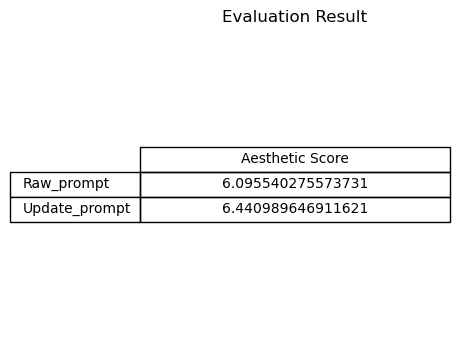

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个 3x3 的表格
fig, ax = plt.subplots(figsize=(4, 4))
ax.axis('off')  # 隐藏坐标轴

# 设置表格的行列数
rows = 1
cols = 2

# 创建数据
data = [[raw_score], [update_score]]

# 创建表头
row_labels = ['Raw_prompt', 'Update_prompt']
col_labels = ['Aesthetic Score']

# 绘制表格
the_table = ax.table(cellText=data,
                    rowLabels=row_labels,
                    colLabels=col_labels,
                    loc='center',
                    cellLoc='center',
                    cellColours=[['none'] * 1] * 2)
# 添加表格标题
ax.set_title('Evaluation Result')

# 调整表格大小
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.5)

# 显示图像
plt.show()